# Requirement 2

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Pricing problem

In [34]:
# Environment variables
NUM_DAYS = 500  # Total number of days
NUM_ROUNDS_PER_DAY = 10  # Number of auction rounds per day
NUM_PRICES = 10  # Number of discrete prices
CHANGE_INTERVAL = 1  # Interval for changing the user buying probability distribution

# Pricing strategy variables
CONVERSION_RATE_MEAN = 0.5  # Mean of the initial conversion rate
CONVERSION_RATE_STD = 0.1  # Standard deviation of the initial conversion rate

# Auction variables
BID_WIN_PROBABILITY = 0.5  # Probability of winning an auction round

In [35]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.t = 0
        self.buying_probabilities = self._generate_buying_probabilities()

    def _generate_buying_probabilities(self):
        return np.random.rand(self.num_arms)

    def reset(self):
        self.buying_probabilities = self._generate_buying_probabilities()

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob

In [36]:
class UCB1:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.total_counts = 0

    def select_arm(self):
        if self.total_counts < self.num_arms:
            return self.total_counts  # Play each arm once initially

        upper_bounds = self.values + np.sqrt((2 * np.log(self.total_counts)) / self.counts)
        return np.argmax(upper_bounds)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [37]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K) / K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate * l_t)
        self.t += 1

In [38]:
class BiddingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, eta)
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget / self.T
        self.lmbd = 0
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        f_t_full = np.array([(self.valuation - b) if b >= m_t else 0 for b in self.bids_set])
        c_t_full = np.array([b if b >= m_t else 0 for b in self.bids_set])
        L = f_t_full - self.lmbd * (c_t_full - self.rho)
        range_L = 2 + (1 - self.rho) / self.rho
        self.hedge.update((2 - L) / range_L)
        self.lmbd = np.clip(self.lmbd - self.eta * (self.rho - c_t), 0, 1 / self.rho)
        self.budget -= c_t

In [39]:
class NonStationaryFirstPriceAuction:
    def __init__(self, available_bids, num_bidders, num_rounds):
        self.available_bids = available_bids
        self.num_bidders = num_bidders
        self.num_rounds = num_rounds
        self.round_counter = 0
        self.bids = self._generate_bids()

    def _generate_bids(self):
        return np.random.choice(self.available_bids, (self.num_rounds, self.num_bidders))

    def reset(self):
        self.bids = self._generate_bids()
        self.round_counter = 0

    def round(self, agent_bid):
        current_round_bids = self.bids[self.round_counter]
        max_bid = np.max(current_round_bids)
        win = agent_bid > max_bid
        self.round_counter += 1
        return max_bid, win

In [40]:
# Initialize Hedge agent for bidding strategy
available_bids = np.linspace(0, 1, NUM_PRICES)
eta = np.sqrt(np.log(len(available_bids)) / (NUM_ROUNDS_PER_DAY * NUM_DAYS))
initial_budget = 5000
valuation = 1

bidding_agent = BiddingAgent(bids_set=available_bids, valuation=valuation, budget=initial_budget, T=NUM_ROUNDS_PER_DAY * NUM_DAYS, eta=eta)
num_bidders = 10

# Initialize Environment and Auction
env = AdversarialPricingEnvironment(num_arms=NUM_PRICES, change_interval=CHANGE_INTERVAL)
auction = NonStationaryFirstPriceAuction(available_bids=available_bids, num_bidders=num_bidders, num_rounds=NUM_ROUNDS_PER_DAY)
pricing_agent = UCB1(num_arms=NUM_PRICES)

# Simulation loop with auction and Hedge agent
total_rewards = 0
cumulative_regret = 0
cumulative_rewards = []
daily_regrets = []
daily_rewards = []
daily_probabilities = []
chosen_bids = []
arm_pulls = np.zeros(NUM_PRICES)
budget_depleted_day = None
cumulative_payments = []

cumulative_payment = 0  # Initialize cumulative payment
for day in range(NUM_DAYS):
    if bidding_agent.budget < 1:
        budget_depleted_day = day
        break

    env.reset()
    auction.reset()

    daily_probabilities.append(env.buying_probabilities.copy())

    chosen_price = pricing_agent.select_arm()

    daily_reward = 0
    for round in range(NUM_ROUNDS_PER_DAY):
        agent_bid = bidding_agent.bid()
        chosen_bids.append(agent_bid)
        arm_pulls[chosen_price] += 1

        max_bid, win = auction.round(agent_bid)

        if win:
            if env.round(chosen_price):
                daily_reward += 1
                cumulative_payment += chosen_price  # Track the payments

        reward = (env.buying_probabilities[chosen_price] - agent_bid) if win else -agent_bid
        bidding_agent.update(env.buying_probabilities[chosen_price] - max_bid, agent_bid, max_bid)

    pricing_agent.update(chosen_price, daily_reward)
    total_rewards += daily_reward
    cumulative_payments.append(cumulative_payment)  # Track the cumulative payment per day

    optimal_reward = np.max(env.buying_probabilities) * NUM_ROUNDS_PER_DAY
    daily_regret = optimal_reward - daily_reward
    cumulative_regret += daily_regret

    daily_rewards.append(daily_reward)
    daily_regrets.append(cumulative_regret)
    cumulative_rewards.append(total_rewards)

    # print(f"Day {day+1}, Daily Reward: {daily_reward}, Total Rewards: {total_rewards}, Daily Regret: {daily_regret}, Cumulative Regret: {cumulative_regret}")

cumulative_probabilities = np.mean(daily_probabilities, axis=0)
optimal_arm = np.argmax(cumulative_probabilities)

most_pulled_arm = np.argmax(pricing_agent.counts)

print(f"Simulation completed. Total rewards: {total_rewards}")
print(f"Cumulative regret: {cumulative_regret}")
print(f"Most pulled arm: {most_pulled_arm}")
print(f"Arm that should have been pulled the most: {optimal_arm}")
print(f"Budget depleted on day: {budget_depleted_day}")


Simulation completed. Total rewards: 155
Cumulative regret: 4377.064433065447
Most pulled arm: 0
Arm that should have been pulled the most: 4
Budget depleted on day: None


<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rbegl\AppData\Local\Temp\ipykernel_9072\2107688168.py:51: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum p_t$')


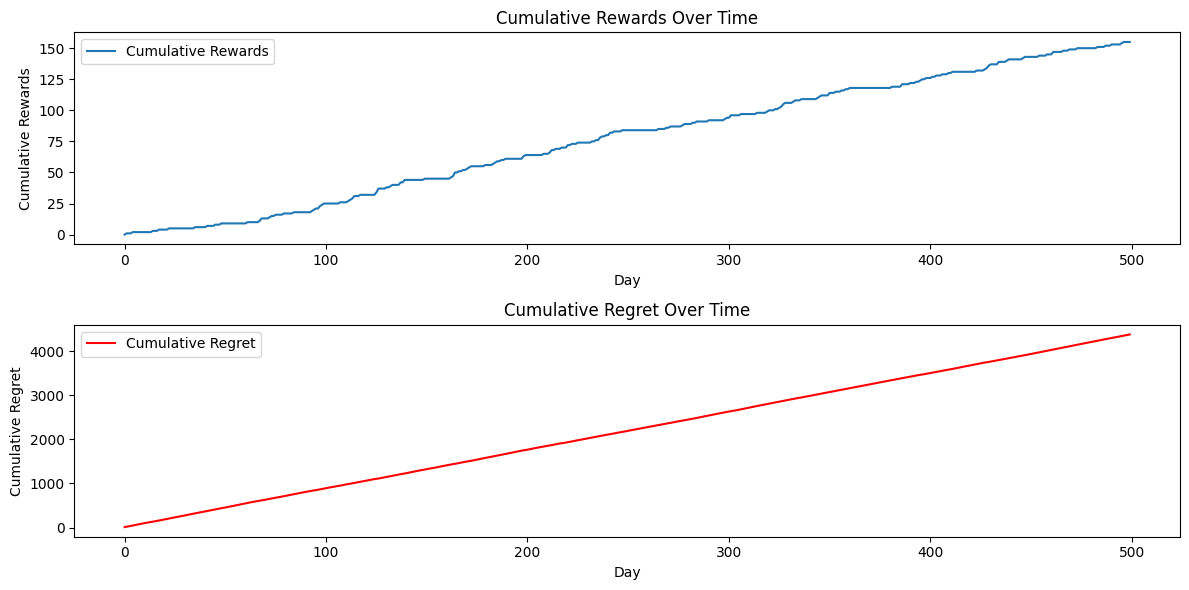

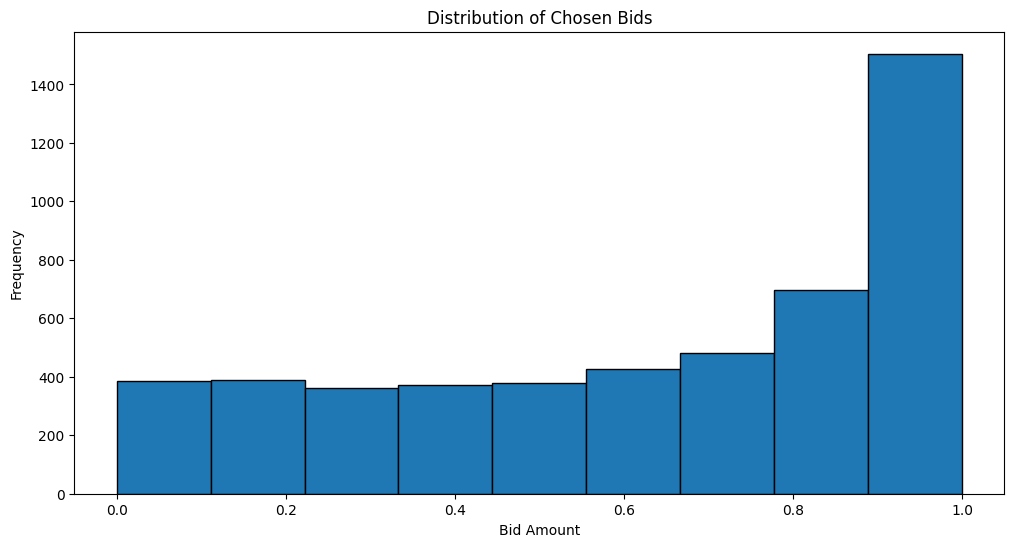

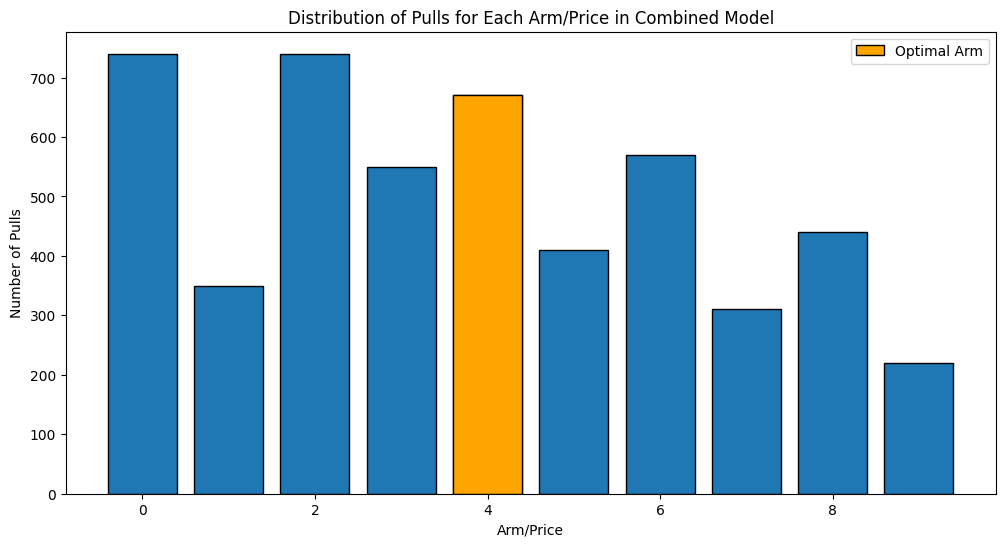

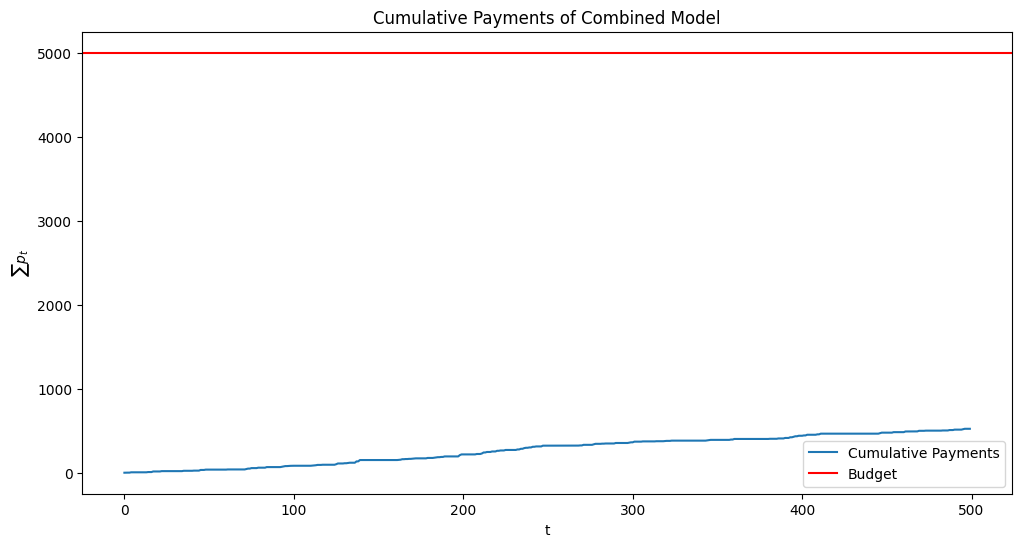

In [41]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(2, 1, 1)
plt.plot(range(len(cumulative_rewards)), cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Day')
plt.ylabel('Cumulative Rewards')
plt.title('Cumulative Rewards Over Time')
plt.legend()
if budget_depleted_day is not None:
    plt.axvline(x=budget_depleted_day, color='r', linestyle='--', label='Budget Depleted')
    plt.legend()


# Plot cumulative regret
plt.subplot(2, 1, 2)
plt.plot(range(len(daily_regrets)), daily_regrets, label='Cumulative Regret', color='red')
plt.xlabel('Day')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Over Time')
if budget_depleted_day is not None:
    plt.axvline(x=budget_depleted_day, color='r', linestyle='--', label='Budget Depleted')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the distribution of chosen bids
plt.figure(figsize=(12, 6))
plt.hist(chosen_bids, bins=available_bids, edgecolor='black')
plt.xlabel('Bid Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Chosen Bids')
plt.show()

# Plot the distribution of pulls for each arm/price
plt.figure(figsize=(12, 6))
plt.bar(range(NUM_PRICES), arm_pulls, edgecolor='black')
plt.xlabel('Arm/Price')
plt.ylabel('Number of Pulls')
plt.title('Distribution of Pulls for Each Arm/Price in Combined Model')
plt.bar(optimal_arm, arm_pulls[optimal_arm], color='orange', edgecolor='black', label='Optimal Arm')
plt.legend()
plt.show()

# Plot cumulative payments
plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_payments)), cumulative_payments, label='Cumulative Payments')
plt.xlabel('t')
plt.ylabel('$\sum p_t$')
plt.title('Cumulative Payments of Combined Model')
plt.axhline(y=initial_budget, color='r', linestyle='-', label='Budget')
plt.legend()
plt.show()

# Seperate Executions


Auction algorithm completed. Budget depleted on day: 3354


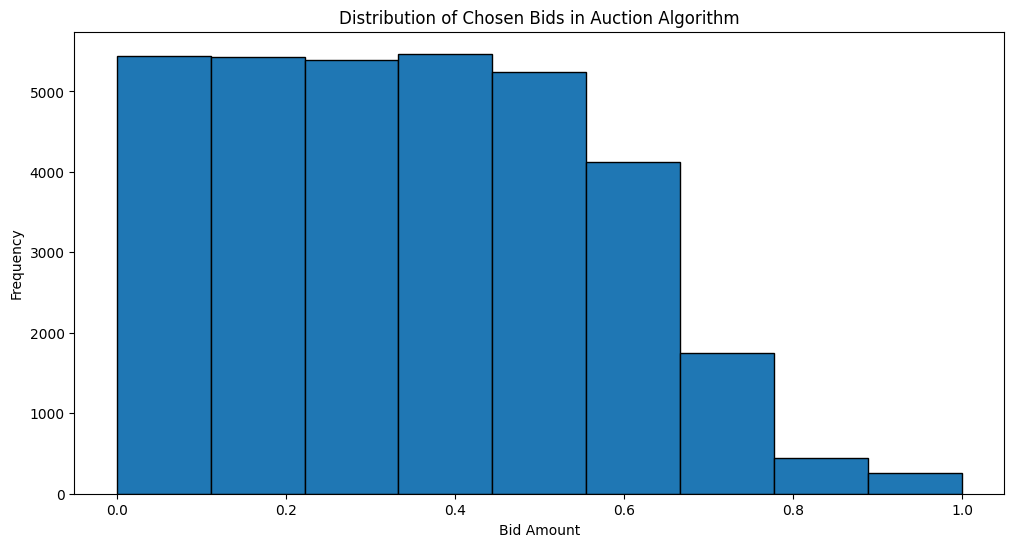

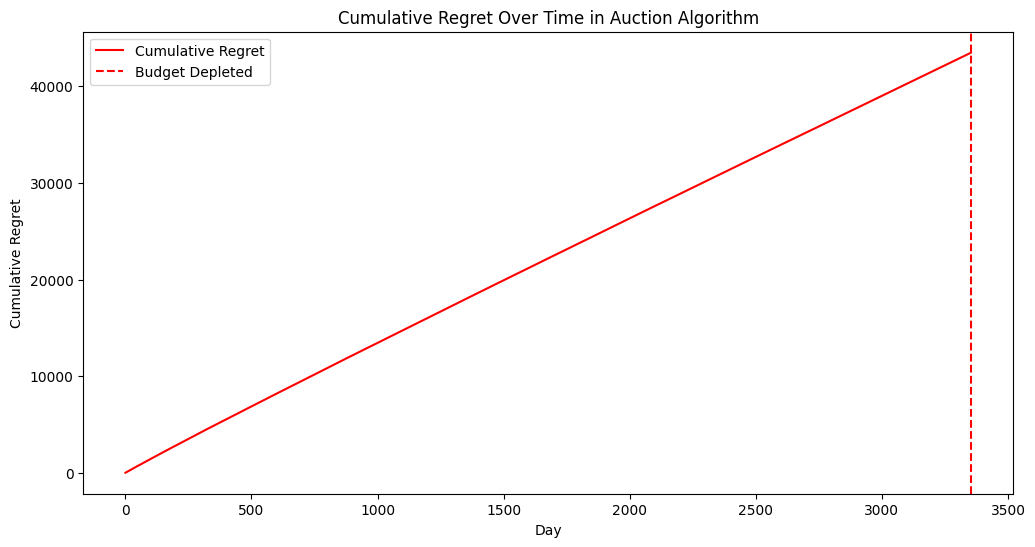

In [42]:
# Initialize Hedge agent for bidding strategy
NUM_DAYS = 5000
available_bids = np.linspace(0, 1, NUM_PRICES)
eta = np.sqrt(np.log(len(available_bids)) / (NUM_ROUNDS_PER_DAY * NUM_DAYS))
initial_budget = 10000
valuation = 1

bidding_agent = BiddingAgent(bids_set=available_bids, valuation=valuation, budget=initial_budget, T=NUM_ROUNDS_PER_DAY * NUM_DAYS, eta=eta)
num_bidders = 10

# Initialize Auction
auction = NonStationaryFirstPriceAuction(available_bids=available_bids, num_bidders=num_bidders, num_rounds=NUM_ROUNDS_PER_DAY)

# Variables for tracking results
chosen_bids = []
daily_regrets = []
cumulative_regret = 0
budget_depleted_day = None

# Simulation loop for auction algorithm
for day in range(NUM_DAYS):
    if bidding_agent.budget < 1:
        budget_depleted_day = day
        break

    auction.reset()

    daily_reward = 0
    for round in range(NUM_ROUNDS_PER_DAY):
        agent_bid = bidding_agent.bid()
        chosen_bids.append(agent_bid)

        max_bid, win = auction.round(agent_bid)

        reward = (valuation - agent_bid) if win else -agent_bid
        bidding_agent.update(reward, agent_bid, max_bid)
        daily_reward += reward

    daily_regret = max(0, NUM_ROUNDS_PER_DAY * valuation - daily_reward)
    cumulative_regret += daily_regret
    daily_regrets.append(cumulative_regret)

    # print(f"Day {day+1}, Daily Reward: {daily_reward}, Cumulative Regret: {cumulative_regret}, Budget: {bidding_agent.budget}")

print(f"Auction algorithm completed. Budget depleted on day: {budget_depleted_day}")

# Plot the distribution of chosen bids
plt.figure(figsize=(12, 6))
plt.hist(chosen_bids, bins=available_bids, edgecolor='black')
plt.xlabel('Bid Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Chosen Bids in Auction Algorithm')
plt.show()

# Plot cumulative regret
plt.figure(figsize=(12, 6))
plt.plot(range(len(daily_regrets)), daily_regrets, label='Cumulative Regret', color='red')
plt.xlabel('Day')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Over Time in Auction Algorithm')
if budget_depleted_day is not None:
    plt.axvline(x=budget_depleted_day, color='r', linestyle='--', label='Budget Depleted')
plt.legend()
plt.show()

<>:89: SyntaxWarning: invalid escape sequence '\s'
<>:89: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rbegl\AppData\Local\Temp\ipykernel_9072\3311346331.py:89: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum p_t$')


Pricing algorithm completed. Total rewards: 25016
Cumulative regret: 20487.293009725116
Most pulled arm: 6
Arm that should have been pulled the most: 8


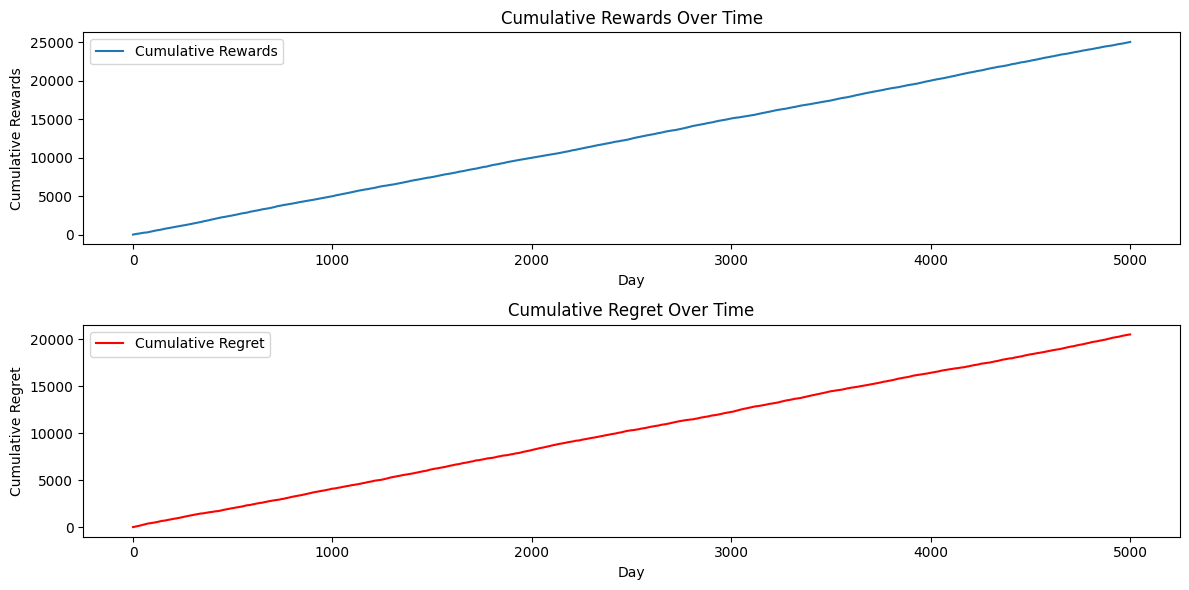

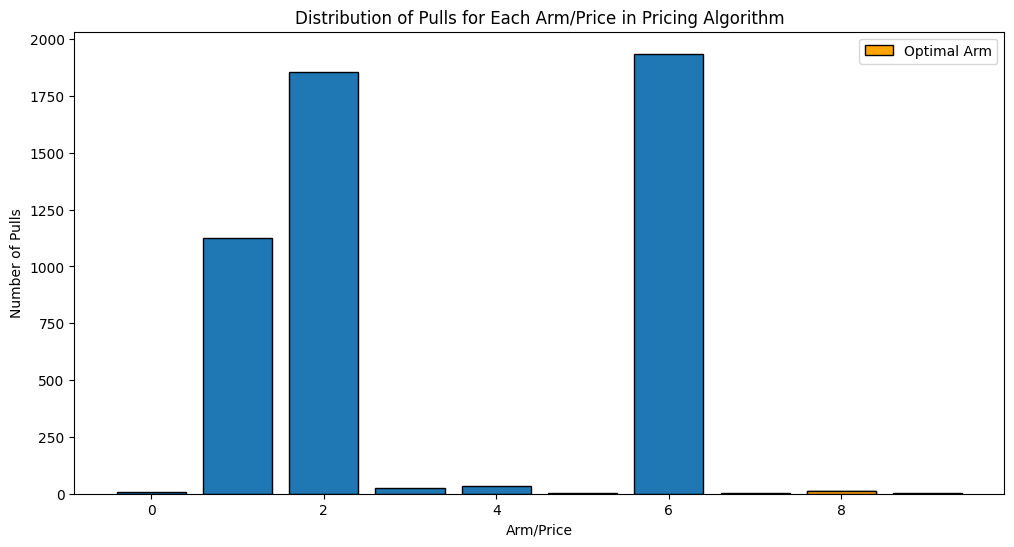

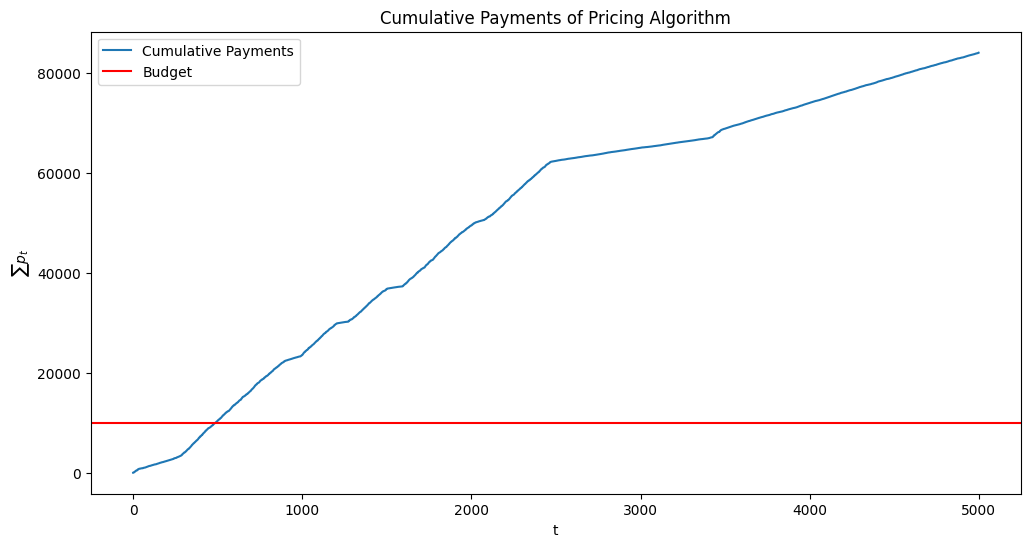

In [43]:
# Initialize Environment and Pricing Agent
env = AdversarialPricingEnvironment(num_arms=NUM_PRICES, change_interval=CHANGE_INTERVAL)
pricing_agent = UCB1(num_arms=NUM_PRICES)

# Variables for tracking results
total_rewards = 0
cumulative_regret = 0
cumulative_rewards = []
daily_regrets = []
daily_rewards = []
daily_probabilities = []
cumulative_payments = []

# Simulation loop for pricing algorithm
cumulative_payment = 0  # Initialize cumulative payment
for day in range(NUM_DAYS):
    env.reset()

    daily_probabilities.append(env.buying_probabilities.copy())

    chosen_price = pricing_agent.select_arm()

    daily_reward = 0
    for round in range(NUM_ROUNDS_PER_DAY):
        if env.round(chosen_price):
            daily_reward += 1
            cumulative_payment += chosen_price  # Track the payments

    pricing_agent.update(chosen_price, daily_reward)
    total_rewards += daily_reward
    cumulative_payments.append(cumulative_payment)  # Track the cumulative payment per day

    optimal_reward = np.max(env.buying_probabilities) * NUM_ROUNDS_PER_DAY
    daily_regret = optimal_reward - daily_reward
    cumulative_regret += daily_regret

    daily_rewards.append(daily_reward)
    daily_regrets.append(cumulative_regret)
    cumulative_rewards.append(total_rewards)

    # print(f"Day {day+1}, Daily Reward: {daily_reward}, Total Rewards: {total_rewards}, Daily Regret: {daily_regret}, Cumulative Regret: {cumulative_regret}")

cumulative_probabilities = np.mean(daily_probabilities, axis=0)
optimal_arm = np.argmax(cumulative_probabilities)

most_pulled_arm = np.argmax(pricing_agent.counts)

print(f"Pricing algorithm completed. Total rewards: {total_rewards}")
print(f"Cumulative regret: {cumulative_regret}")
print(f"Most pulled arm: {most_pulled_arm}")
print(f"Arm that should have been pulled the most: {optimal_arm}")

# Plot the results for the pricing algorithm
plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(2, 1, 1)
plt.plot(range(len(cumulative_rewards)), cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Day')
plt.ylabel('Cumulative Rewards')
plt.title('Cumulative Rewards Over Time')
plt.legend()

# Plot cumulative regret
plt.subplot(2, 1, 2)
plt.plot(range(len(daily_regrets)), daily_regrets, label='Cumulative Regret', color='red')
plt.xlabel('Day')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the distribution of pulls for each arm/price
plt.figure(figsize=(12, 6))
plt.bar(range(NUM_PRICES), pricing_agent.counts, edgecolor='black')
plt.xlabel('Arm/Price')
plt.ylabel('Number of Pulls')
plt.title('Distribution of Pulls for Each Arm/Price in Pricing Algorithm')
plt.bar(optimal_arm, pricing_agent.counts[optimal_arm], color='orange', edgecolor='black', label='Optimal Arm')
plt.legend()
plt.show()

# Plot cumulative payments
plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_payments)), cumulative_payments, label='Cumulative Payments')
plt.xlabel('t')
plt.ylabel('$\sum p_t$')
plt.title('Cumulative Payments of Pricing Algorithm')
plt.axhline(y=initial_budget, color='r', linestyle='-', label='Budget')
plt.legend()
plt.show()